This notebook examines data from the Register of Livestock Establishments ([Registro de Establecimientos Pecuarios](https://https://www.sag.gob.cl/ambitos-de-accion/registro-de-establecimientos-pecuarios)) maintained by the Agriculture and Livestock Service of the Chilean Agricultural Ministry. According to the web page, "The RUP corresponds to the mandatory identification of each livestock establishment in the country." The data were obtained (with some difficulty) under the Transparency Act by C. Leibsch, a Chilean researcher and animal advocate.

There is one spreadsheet for "pigs" and another for "birds". The spreadsheets don't contain any further information about animal type or life stage, but they do contain farm coordinates and animal numbers, along with some other geographical information (such as the Chilean region each establishment is in).

In [1]:
import os
import numpy as np
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pyproj

In [2]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define the farm sizes we are interested in, read the data, and display a couple of rows.

In [11]:
pig_range = (100, 500)
bird_range = (5000, 10000)
columns_to_drop = ['OFICINA', 'RUP', 'RUP_NOMBRE', 'HUSO']

In [4]:
df1 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-porcinos-2022 (1).xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-aves-2022 (2) (3).xlsx')

In [5]:
display(df1.sample(1))
display(df2.sample(1))

,REGION,PROVINCIA,COMUNA,OFICINA,RUP,RUP_NOMBRE,DIRECCION_ESTABLECIMIENTO,LOCALIDAD,COORDENADA_X,COORDENADA_Y,HUSO,CANTIDAD
25430,DE LA ARAUCANIA,CAUTIN,PERQUENCO,OFICINA TEMUCO,09.1.13.0708,HIJUELA,REDUCION,PERQUENCO,NaN,NaN,18.0,0


,REGION,PROVINCIA,COMUNA,OFICINA,RUP,RUP_NOMBRE,DIRECCION_ESTABLECIMIENTO,LOCALIDAD,COORDENADA_X,COORDENADA_Y,HUSO,CANTIDAD
35184,DE LOS LAGOS,OSORNO,PURRANQUE,OFICINA RIO NEGRO,10.3.03.0854,COLONIA PONCE,SECTOR COLONIA PONCE,PURRANQUE,660412.0,5461216.0,18.0,14


The next cell creates histograms of number of animals per farm ('CANTIDAD' field in the original spreadsheets') and cumulative animal numbers. Taken at face value, these plots would indicate that although most farms are small, most animals are on the largest farms. However, there are two reasons to suspect that the actual numbers in these plots may be misleading:



1.   There are many farms (excluded from these plots) with CANTIDAD=0. It is not clear why this is, or how many farms these animals might actually have.
2.   There are some farms with very large animal numbers (e.g. ~50000 pigs). If we set min_pigs=30000 and map the resulting farms, we can see that these farms are real and they are large CAFOs. It is not clear that they are larger than other CAFOs, though.

Overall, the animal numbers in this dataset are useful but should be used with some caution.

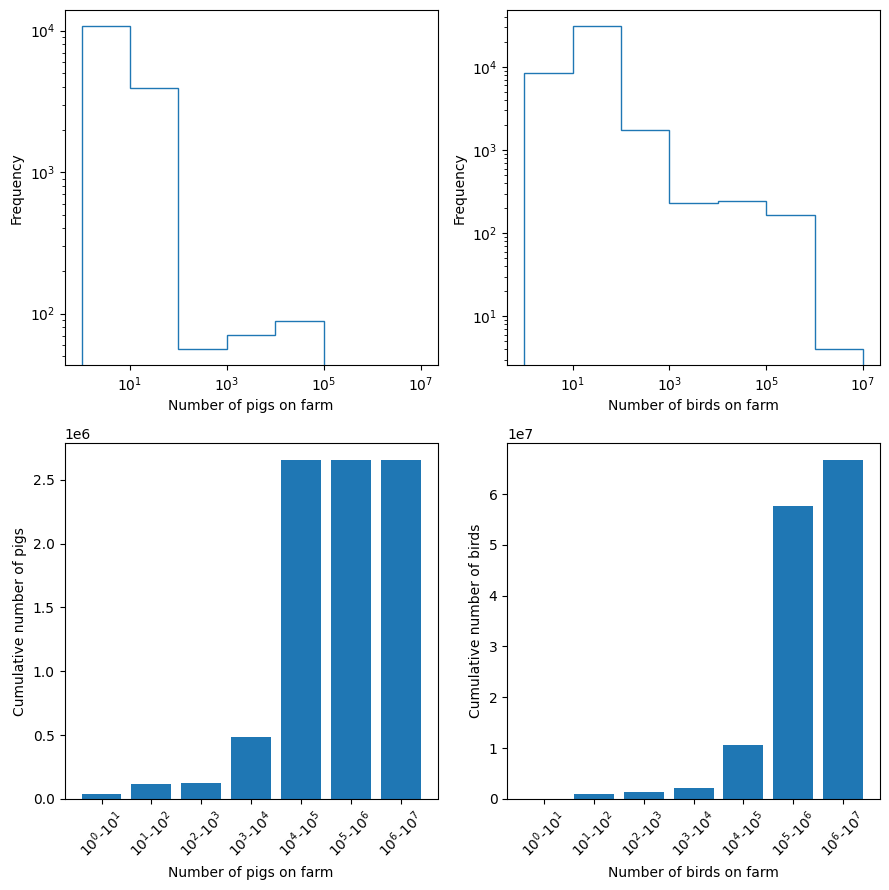

In [6]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

def histo(df, ax_a, ax_b, animal):

  # Histogram
  to_show = df[df['CANTIDAD'] > 0]
  n, bins, _ = ax_a.hist(to_show['CANTIDAD'], bins=[1, 10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7],\
                         log=True, histtype='step')
  ax_a.set_xscale('log')
  ax_a.set_xlabel(f'Number of {animal} on farm')
  ax_a.set_ylabel('Frequency')

  # Cumulative numbers of animals on small --> large farms
  cumulative = []
  for n, bin in enumerate(bins[:-1]):
    temp = df[(df['CANTIDAD'] >= bin) & (df['CANTIDAD'] < bins[n+1])]
    temp = temp['CANTIDAD'].sum()
    if n == 0:
      cumulative.append(temp)
    else:
      cumulative.append(temp+cumulative[n-1])
  xpos = range(len(cumulative))
  ax_b.bar(x=xpos, height=cumulative)
  ax_b.set_xticks(xpos, [r"10$^0$-10$^1$", "10$^1$-10$^2$", "10$^2$-10$^3$",\
                         "10$^3$-10$^4$", "10$^4$-10$^5$", "10$^5$-10$^6$", "10$^6$-10$^7$"],\
                  rotation=45, ha='center')
  ax_b.set_xlabel(f'Number of {animal} on farm')
  ax_b.set_ylabel(f'Cumulative number of {animal}')

histo(df1, ax1, ax3, 'pigs')
histo(df2, ax2, ax4, 'birds')
plt.tight_layout()

In [7]:
def convertCoords(row):
    crs_from = pyproj.CRS("EPSG:32719")
    crs_to = pyproj.CRS("EPSG:4326")
    lat, lon = pyproj.Transformer.from_crs(crs_from, crs_to).\
                 transform(row['COORDENADA_X'], row['COORDENADA_Y'])
    return pd.Series({'Longitude':lon, 'Latitude':lat})

In [16]:
def describe_and_refine(df, animal_type, size_range):

  print(f"There are {df.shape[0]} entries in the {animal_type} spreadsheet")

  temp = df[df['CANTIDAD'] == 0]
  print(f"{len(temp)} farms report 0 {animal_type}")

  temp = df[(df['CANTIDAD'] < size_range[0]) & (df['CANTIDAD'] > 0)]
  print(f"There are {len(temp)} farms with 0 < {animal_type} < {size_range[0]}")
  print(f"  - They account for {temp['CANTIDAD'].sum()} {animal_type}")

  df = df[(df['CANTIDAD'] > size_range[0]) & (df['CANTIDAD'] < size_range[1])]
  print(f"There are {df.shape[0]} farms with  {size_range[0]} < {animal_type} < {size_range[1]}")
  print(f"  - They account for {df['CANTIDAD'].sum()} {animal_type} \n")

  print(df.groupby(['REGION']).size().sort_values(ascending=False))
  print("")

  #PRINT SOMETHING ABOUT DROPPED COLUMNS
  df = df.drop(columns=columns_to_drop).reset_index(drop=True)

  df[['Longitude', 'Latitude']] = df.apply(convertCoords, axis=1)
  df = df.sort_values(by='Latitude', ascending=False).reset_index(drop=True)
  df = df[~df['Latitude'].isnull()]

  gdf = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))
  gdf = gdf.drop(columns=["Latitude", "Longitude", "COORDENADA_X", "COORDENADA_Y"])

  fc = geemap.geopandas_to_ee(gdf[["geometry"]])

  return fc

In [17]:
pigs = describe_and_refine(df1, 'pigs', pig_range)
birds = describe_and_refine(df2, 'birds', bird_range)

There are 44444 entries in the pigs spreadsheet
29522 farms report 0 pigs
There are 14706 farms with 0 < pigs < 100
  - They account for 116374 pigs
There are 48 farms with  100 < pigs < 500
  - They account for 8427 pigs 

REGION
DE LOS LAGOS                               11
DEL MAULE                                   7
METROPOLITANA                               6
DE LA ARAUCANIA                             5
DEL BIO BIO                                 5
DE LOS RIOS                                 4
DE ARICA Y PARINACOTA                       3
DEL LIBERTADOR GRAL. BERNARDO O'HIGGINS     3
DE ?UBLE                                    2
DE TARAPACA                                 1
DE VALPARAISO                               1
dtype: int64

There are 45037 entries in the birds spreadsheet
3147 farms report 0 birds
There are 41410 farms with 0 < birds < 5000
  - They account for 1642773 birds
There are 61 farms with  5000 < birds < 10000
  - They account for 465285 birds 

REGION
DE VAL

In [18]:
Map = geemap.Map()
Map.centerObject(pigs.first().geometry(), 16)

os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

Map.add_basemap("HYBRID")
Map.addLayer(pigs, {'color':'pink', 'width':6}, "Pig farms")
Map.addLayer(birds, {'color':'cyan', 'width':6}, "Bird farms")

Map